In [13]:
import numpy as np

n_tmpl = 6
n_wrld = 45


def init_candidate_dict(n_tmpl, n_wrld):
        D= {}
        for i in range(n_tmpl): 
            D[f'{i}'] = list(range(n_wrld))
        return D
   
   
def convert_string_to_list(string):
    mapping = {'A': 0, 'T': 3, 'C': 1, 'G': 2}
    result = []
    for char in string:
        if char in mapping:
            result.append(mapping[char])
        else:
           print('invalid character. Only allowed nucleotides are ACTG')
           break
    return result
        
    
def build_BG_matrix(n, lst, m = 6):
    BG = np.zeros((n, n), dtype=int)
    
    for i in range(n):
        for j in range(n):
            if (i <= 3 or j <= 3) and (i + j == n - 1):
                BG[i, j] = 1
            elif i > 3 and j > 3 and lst[i] + lst[j] == 3 and np.abs(i - j) >= m-1:
                BG[i, j] = 1
    return BG


def motif_ngh_dct(m):
    graph = {}
    for i in range(m):
        if i == 0:
            graph[str(i)] = [1, m-1]
        elif i == m-1:
            graph[str(i)] = [0, m-2]
        elif i == m//2 or i == m//2 - 1:
            graph[str(i)] = [i-1, i+1]
        else:
            graph[str(i)] = [i-1, i+1, m-i-1]
    return graph


def backbone_bonds_matrix(n):
    # Initialize an empty 2D array filled with zeros
    array = np.zeros((n, n), dtype=int)
    # Set ones in adjacent entries
    array[np.diag_indices(n - 1)[1] , np.diag_indices(n - 1)[0]+1] = 1
            
    return array + array.T


    

def stats_filter(m, lst, candidates_dct ):
    
    # Set up array with ith entry size of the neigh of the i-th vertex in motif
    if m==2:
        ngh_mtf = np.ones(m, dtype = int)
    else:
        ngh_mtf = 3*np.ones(m, dtype = int)
        ngh_mtf[[0,m-1, m//2 , m//2 - 1]] = 2
        
    #Set up array with ith entry size of the neigh of the i-th vertex in  world graph
    n     = len(lst)
    dlt_g = backbone_bonds_matrix(n)
    B_g   = build_BG_matrix(n, lst)
    ngh_wrld  = np.sum(dlt_g + B_g, axis = 1)
    
    #Remove from the candidates set of a motiv vertex all the verteces in wrld graph with lower degree
    for i in range(m):
        if i not in [0,m-1, m//2 , m//2 - 1]:
            condition = np.where(ngh_wrld < ngh_mtf[i])
            candidates_dct[str(i)] = list(np.delete(np.array(candidates_dct[str(i)] ),condition))
    return candidates_dct


def topology_filter(m, lst, candidates_dct):

    nhg_mtf = motif_ngh_dct(m) #neighbhors of motif node
    dlt_g = backbone_bonds_matrix(len(lst))
    B_g   = build_BG_matrix(len(lst), lst)
    D_g =  dlt_g + B_g 
    
    print(D_g.shape)
    for i in range(m): #lopp over vertices motif
        for j in nhg_mtf[str(i)]: # loop of neigh mot vertex
            #indices of condidates for ith motif node that have a neigh that is not in the candidate set of any of the neighbs of the ith motif node
            indx_remove = np.where(np.sum(D_g[candidates_dct[str(i)]][:,candidates_dct[str(j)]], axis = 1) == 0)
            candidates_dct[str(i)] = list(np.delete(np.array(candidates_dct[str(i)] ),indx_remove))
            
    return candidates_dct





In [19]:
import numpy as np

def apt_filter(m, lst, candidates_dct, l_fix= 4):
    n = len(lst)
    
    # Remove unnecessary elements from candidates_dct
    
    for i in range(m):
        for count, j in enumerate([0, 1, 2, 3, n-1, n-2, n-3, n-4]):
            if count != i:
                try:
                    candidates_dct[str(i)].remove(j)
                except ValueError:
                    pass
    

    # Define function motif_ngh_dct and build_BG_matrix
    nhg_mtf = motif_ngh_dct(m) #neighbhors of motif node
    B_g   = build_BG_matrix(len(lst), lst, m)
  
    # Initialize motifs list
    motifs = []
    motifs_vect =[]
    # Iterate over the candidates for the first motif node
    range_loop = candidates_dct[str(0)].copy()
    range_loop_2 = candidates_dct[str(m//2)].copy()
    for i in range_loop[:]:
        # Check if i is within range
        if l_fix-1 <= i <= n-l_fix-1:
            flag = False

            # If the condition satisfies for the first half of the motif
            if  np.any([i+count not in candidates_dct[str(m//2-k)] for count,k in enumerate(range(m//2-1,0,-1),1)]):
                
                for k in range(m//2):
                    try:
                        candidates_dct[str(k)].remove(i + k)
                    except ValueError:
                        pass

            else:
                # Check the condition for the second half of the motif
                for j in range_loop_2:
                    if np.any([j+i not in candidates_dct[str(m//2+i)] for i in range(1, m//2)]):
                        for k in range(m//2, m):
                            try:
                                candidates_dct[str(k)].remove(j + k-m//2)
                            except ValueError:
                                pass
                    elif (j >= i+5 and j <= n-5 and 
                          np.all(B_g[list(range(j, j+m//2))][:,list(range(i, i+m//2))] == np.eye(m//2, dtype=int))):
                        flag = True
                        
                        #store hit motifs as pairs
                        motif = [(i+k, j+m//2-1-k) for k in range(m//2)]
                        #store hits motifs as vectors
                        motif_vect = [i+k for k in range(m//2)]
                        for k in range(m//2):
                            motif_vect.append(j+k)
                            
                        motifs.append(motif)
                        motifs_vect.append(np.asarray(motif_vect))

            # Update holder_dct if motif not found
            if not flag:
                for k in range(m//2):
                    try:
                        candidates_dct[str(k)].remove(i + k)
                    except ValueError:
                        pass

    return candidates_dct, motifs, motifs_vect


def compatible(motif_1, motif_2):
     diff= motif_1 - motif_2
     compatible= False
     if np.all(diff==0):
         compatible= True
     else:
          for i in range(len(diff)//2-1,0, -1):
               if np.all(diff[:i+1]!= 0) and np.all(diff[-i-1:]!= 0) and np.all(diff[i+1:-i-1]==0):
                    compatible== True
                    break
     return compatibility

In [14]:
def find_largest_compatible_sets(arrays):
    def compatible(motif_1, motif_2):
        diff = motif_1 - motif_2
        compatible= False
        if np.all(diff==0):
            compatible= True
        else:
            for i in range(len(diff)//2-1,0, -1):
                if np.all(diff[:i+1]!= 0) and np.all(diff[-i-1:]!= 0) and np.all(diff[i+1:-i-1]==0):
                        compatible== True
                        break
        return compatibility
    
    def is_compatible(array1, array2):
        return compatible(array1, array2)
    '''
    def dfs(array, visited):
        visited.add(array)
        for neighbor in graph[array]:
            if neighbor not in visited:
                dfs(neighbor, visited)
    '''
    graph = {array: set() for array in arrays}
    for i, array1 in enumerate(arrays):
        for array2 in arrays[i + 1:]:
            if is_compatible(array1, array2):
                graph[array1].add(array2)
                graph[array2].add(array1)
    '''
    largest_sets = set()
    visited = set()
    for array in arrays:
        if array not in visited:
            current_set = set()
            dfs(array, current_set)
            if len(current_set) > len(largest_sets):
                largest_sets = current_set

    return largest_sets
    
'''
    return graph
# Example usage:





In [10]:
def from_motifs_to_DB(motifs= None, lst= None):
    n_lst = len(lst)
    m_mtf = len(motif[0])
    db_string = '.'*n_lst
    for motif in motifs: 
        for i in range(m_mtf//2):
            db_string[motif[i]] = '('
        for i in range(m_mtf//2, m_mtf):
            db_string[motif[i]] = ')'
    return db_string


/local/hdd/climaco/anaconda3/envs/aptamer_graph/lib/python3.9/site-packages/forgi/visual/mplotlib.py:118: RuntimeWarning: invalid value encountered in divide
  norm_vec/=ftuv.magnitude(norm_vec)


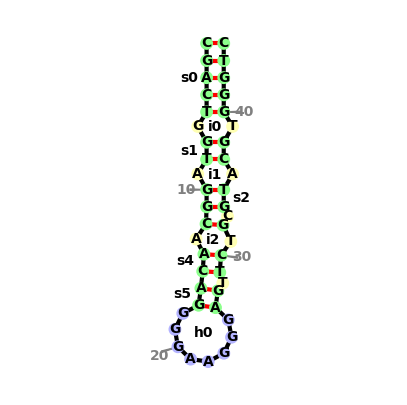

In [82]:
## Get plots
import numpy as np
import matplotlib.pyplot as plt
import forgi.visual.mplotlib as fvm
import forgi
from forgi.graph.bulge_graph import BulgeGraph

# Example sequence and structure
sequence = "CGACTGGTAGGCAACAGGGGAAGGGAGTTCTGCGTACGTGGGTCG"
structure = "(((((.((.(((.((((........)).)).).)).)).)))))"

# Convert sequence and structure to a BulgeGraph object
plt.figure(figsize=(5,5))
bg = BulgeGraph.from_dotbracket(structure,sequence)


fvm.plot_rna(bg, text_kwargs={"fontweight":"black"}, lighten=0.7,backbone_kwargs={"linewidth":3})
plt.show()
# Plot using matplotlib

  




In [23]:
import time
start = time.time()
strn15  = "CGACGGAGGTGGTGTCTTGGACAGTGGTATTCGCAGTTGCGTCG"

arr = convert_string_to_list(strn15)
#Bg = build_BG_matrix(len(arr), arr)
C = init_candidate_dict(4, len(arr))
#C2 = stats_filter(6, arr, C)
#C3 = topology_filter(6, arr, C2)
C4, motifs, motifs_vect= apt_filter(4, arr, C)
print(time.time() - start)
list(set(motifs[0] + motifs[1]))

0.05081987380981445


[(5, 16), (6, 15), (7, 14)]

In [62]:
#check if a nucleotide is mapped in two different nucleotides,
def any_pair_within_threshold(tuple_list):
    
    tuples_array = np.array(list(set(tuple_list)))
    if len(tuples_array == len(tuple_list) ):
        return True
    else:
        pairwise_differences = tuples_array[:, None] - tuples_array
        flag = True
        for i in range(len(tuple_list)):
            hold = np.delete(pairwise_differences[i], i, axis=0)
            if np.min(hold) == 0:
                flag= False
                break
    
    return flag

# Example usage:

threshold = 0
result = any_pair_within_threshold(motifs[0] + motifs[1])
print("Any pair within threshold:", result)

Any pair within threshold: True


In [108]:
import time

strn15  = "CGACGGAGGTGGTGTCTTGGACAGTGGTATTCGCAGTTGCGTCG"

arr = convert_string_to_list(strn15)
Bg = build_BG_matrix(len(arr), arr)
print(Bg)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [67]:
import time
start = time.time()
M1 = build_BG_matrix(len(arr), arr)
print(time.time() - start)
start = time.time()
M2 = build_BG_matrix2(len(arr), arr)
print(time.time() - start)

0.001081705093383789
0.0009171962738037109


In [19]:
neig2

{'0': [1, 3], '1': [0, 2], '2': [1, 3], '3': [0, 2]}

In [18]:
neig = generate_motif(6)
print(neig)
import time
start = time.time()
neig = generate_motif(4)
print(time.time() - start)
start = time.time()
neig2 = generate_motif2(4)
print(time.time() - start)

{'0': [1, 5], '1': [0, 2, 4], '2': [1, 3], '3': [2, 4], '4': [3, 5, 1], '5': [0, 4]}
0.00011086463928222656
9.655952453613281e-05


In [ ]:
''' seems slower
def build_BG_matrix(n, lst):
    BG = np.zeros((n, n), dtype=int)
    
    # Create indices
    i, j = np.indices((n, n))
    
    # Condition 1: i or j <= 4 and i + j = n + 1
    condition1 = np.logical_and(np.logical_or(i <= 4, j <= 4), i + j == n + 1)
    # Condition 2: i, j > 4 and lst[i] + lst[j] = 3 and |i - j| > 5
    tile_lst =  np.tile(lst, (n, 1))
    condition2 = np.logical_and(np.logical_and(i > 4, j > 4), np.logical_and(tile_lst + tile_lst.T == 3, np.abs(i - j) > 5))
    # Fill BG matrix
    BG[condition1 | condition2] = 1
    
    return BG
'''   